## importa le librerie necessarie


In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2025-01-22 09:18:14.274929: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# parte di processing dei dati di input

In [2]:
# path al file h5 scaricato 
# inserisci il path del tuo computer dove hai salvato il file
dataset_path = "/Users/mginolfi/Teaching/Sergio-Unifi/Galaxy10_DECals.h5"

In [3]:
# caricamento del dataset; andiamo a caricare le immagini e le labels dal file totale
# questa operazione potrebbe richiedere un po' di tempo
with h5py.File(dataset_path, "r") as f:
    all_images = np.array(f["images"])
    all_labels = np.array(f["ans"])


# conversione delle labels in formato categorico (10 classi globali)
all_labels = to_categorical(all_labels, 10)

In [4]:
# selezione delle classi desiderate; il file originale ha piu' classi, ma noi vogliamo solo queste quattro,
# corrispondenti a galassie con caratteristiche morfologiche ben definite: 
# merging, galassie ellittiche, galassie a spirale, galassie edge-on. I numeri delle classi corrispondono alla tabella
# su https://astronn.readthedocs.io/en/latest/galaxy10.html
desired_classes = {
    1: "Merging Galaxies",
    2: "Round Galaxies",
    6: "Spiral Galaxies",
    8: "Edge-on Galaxies"
}

In [5]:
# andiamo ora a filtrare le immagini e le labels per selezionare solo le classi desiderate
selected_indices = np.isin(np.argmax(all_labels, axis=1), list(desired_classes.keys()))
images = all_images[selected_indices]  # Filtra le immagini
labels = np.argmax(all_labels[selected_indices], axis=1)  # Ritorna le labels come interi

# mappatura delle labels alle nuove classi 0, 1, ..., len(desired_classes)-1
# in questo modo le labels saranno 0 per le merging, 1 per le galassie ellittiche, 2 per le galassie a spirale e 3 per le galassie edge-on
label_mapping = {old_label: new_label for new_label, old_label in enumerate(desired_classes.keys())}
labels = np.array([label_mapping[label] for label in labels])


# verifica consistenza della forma dei dati
print(f"Immagini selezionate: {images.shape}")
print(f"Labels selezionate: {labels.shape}")
print(f"Classi dopo il mapping: {np.unique(labels)}")

Immagini selezionate: (7750, 256, 256, 3)
Labels selezionate: (7750,)
Classi dopo il mapping: [0 1 2 3]


In [6]:
# ora che abbiamo le immagini e le labels delle classi desiderate, facciamo una operazione di resizing delle immagini
# per ridurre la loro dimensione a 128x128 pixel. In questo modo riduciamo la complessita' del modello e velocizziamo
# l'addestramento. Inoltre, la stessa funzione, resize, normalizza i valori dei pixel tra 0 e 1. 

from skimage.transform import resize

# resize e normalizzazione
images = np.array([resize(img, (128, 128)) for img in images]) 

# verifica che il massimo valore di pixel sia 1
images[0].max()

0.999659483695433

## visualizzazione dei dati selezionati

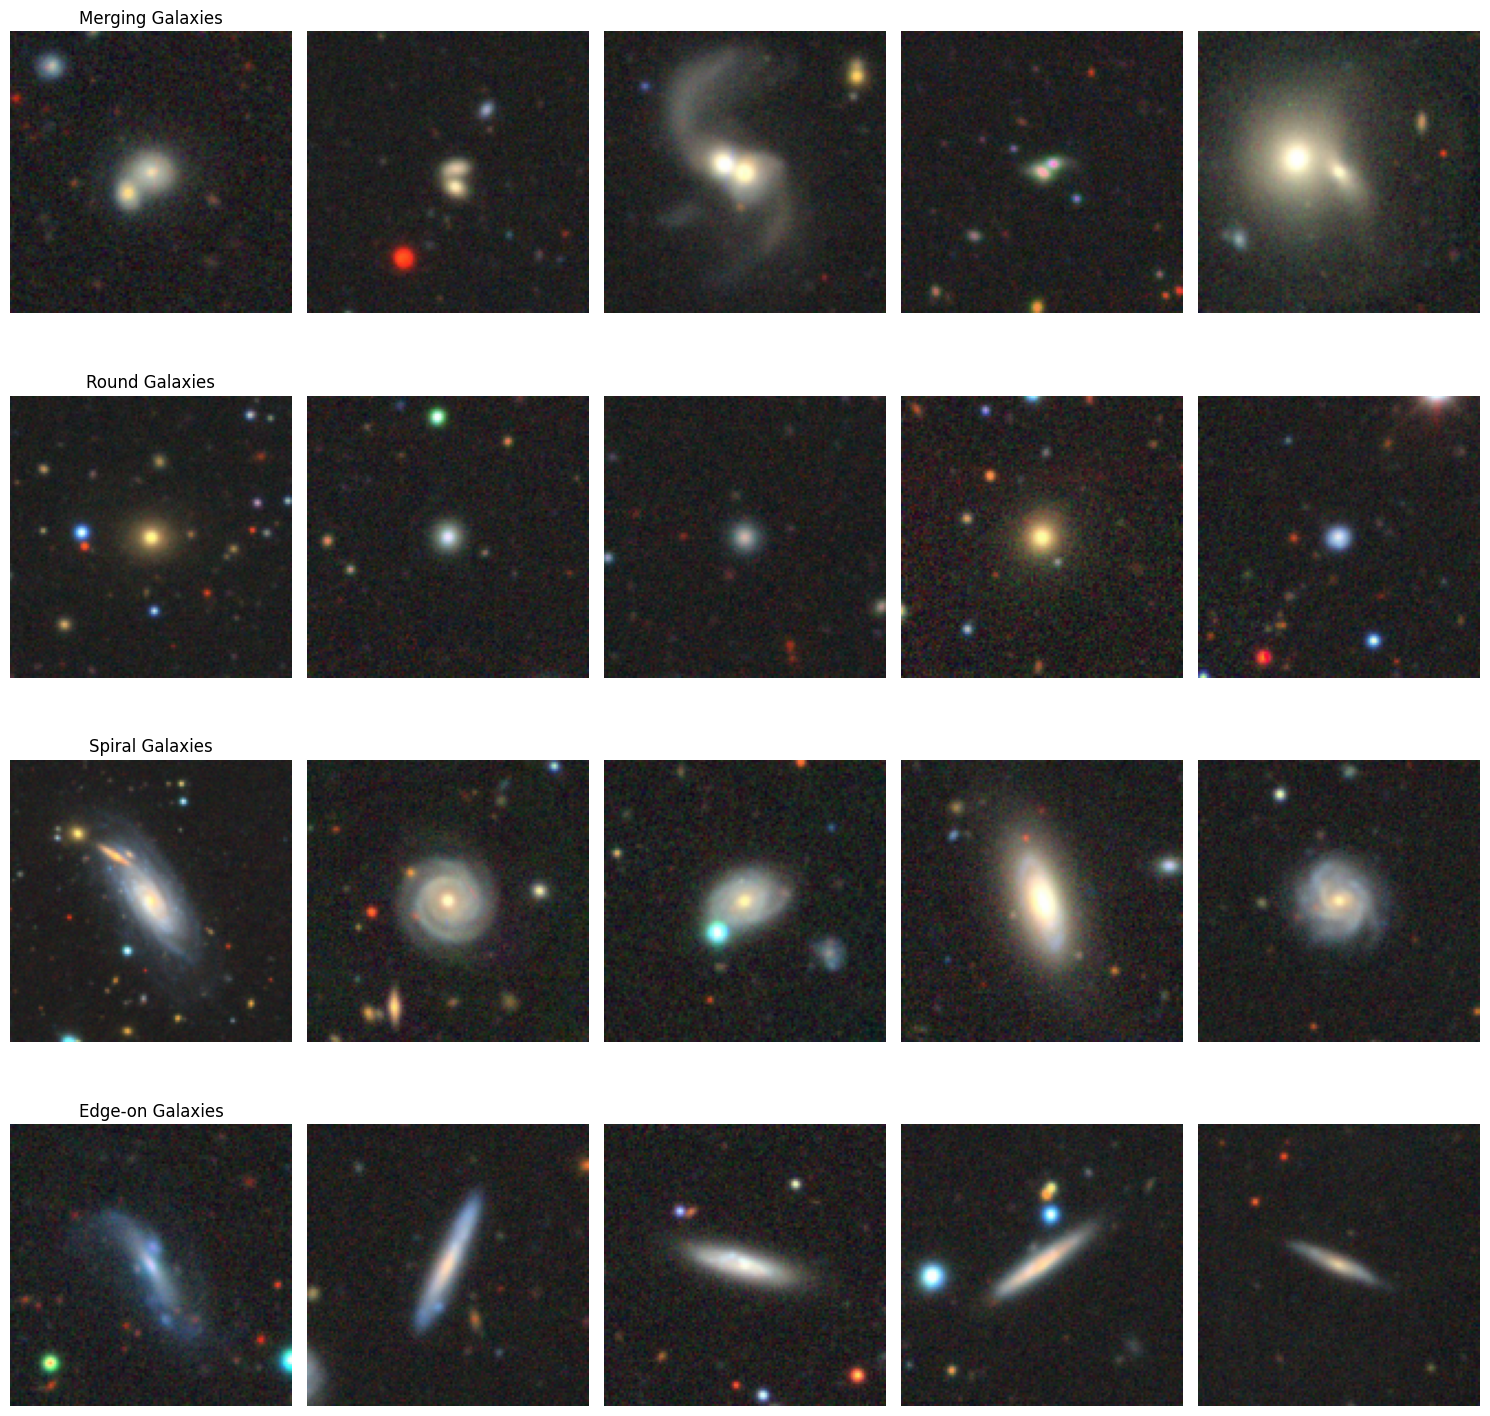

In [7]:
# nuovo dizionario che mappa le nuove classi alle descrizioni
new_desired_classes = {label_mapping[old_label]: class_name for old_label, class_name in desired_classes.items()}

# seleziona 5 esempi random per classe e visualizzali con un plot che mostra 4 righe (una per classe) e 5 colonne (una per esempio)
num_examples_per_class = 5
fig, axes = plt.subplots(len(new_desired_classes), num_examples_per_class, figsize=(15, 15))

for class_id, class_name in new_desired_classes.items():
    class_indices = np.where(labels == class_id)[0]  # Usa le nuove classi
    random_indices = np.random.choice(class_indices, num_examples_per_class, replace=False)
    
    for i, idx in enumerate(random_indices):
        ax = axes[class_id, i]  # `class_id` corrisponde all'indice della classe rimappata
        ax.imshow(images[idx])
        ax.axis('off')
        if i == 0:
            ax.set_title(class_name, fontsize=12)

plt.tight_layout()
plt.show()


## addestramento della pipeline di deep learning

In [8]:
# divisione del dataset in training, validation e test set
# nella attuale divisione, il training set conterra' il 60% delle immagini, il validation set il 20% e il test set il 20%
x_train, x_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# verifica delle dimensioni dei set
print(f"Training set: {x_train.shape}")
print(f"Validation set: {x_val.shape}")
print(f"Test set: {x_test.shape}")

Training set: (4650, 128, 128, 3)
Validation set: (1550, 128, 128, 3)
Test set: (1550, 128, 128, 3)


In [9]:
# one-hot encoding delle label per addestrare la rete neurale. In questo modo, le labels saranno vettori binari
# con un 1 nella posizione corrispondente alla classe e 0 in tutte le altre posizioni. Ad esempio, la classe 2 
# (galassie ellittiche) sara' codificata come [0, 1, 0, 0].
num_classes = len(desired_classes)
y_train_onehot = to_categorical(y_train, num_classes)
y_val_onehot = to_categorical(y_val, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)

In [17]:
# creazione del modello di rete neurale convoluzionale
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=x_train.shape[1:]),
    MaxPooling2D((3, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((3, 3)),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# riassunto del modello, con informazioni sui layer e sui parametri
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 42, 42, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 10816)             0         
                                                                 
 dense_4 (Dense)             (None, 32)               

In [18]:
# compilazione del modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# allenamento del modello
# questa operazione potrebbe richiedere un po' di tempo
# iniziamo con 30 epoche e un batch size di 128, poi possiamo modificare questi parametri per ottenere risultati migliori.

from tensorflow.keras.callbacks import EarlyStopping

# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(x_train, y_train_onehot, validation_data=(x_val, y_val_onehot), epochs=30, batch_size=128, callbacks=[early_stopping])

Epoch 1/30


2025-01-22 09:24:17.341260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - ETA: 0s - loss: 1.2873 - accuracy: 0.4069

2025-01-22 09:24:23.246040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 7s 166ms/step - loss: 1.2873 - accuracy: 0.4069 - val_loss: 1.1826 - val_accuracy: 0.4581
Epoch 2/30
37/37 [==============================] - 4s 122ms/step - loss: 1.1081 - accuracy: 0.5239 - val_loss: 1.0293 - val_accuracy: 0.5535
Epoch 3/30
37/37 [==============================] - 4s 121ms/step - loss: 0.9299 - accuracy: 0.6183 - val_loss: 0.8247 - val_accuracy: 0.6787
Epoch 4/30
37/37 [==============================] - 4s 118ms/step - loss: 0.7701 - accuracy: 0.7030 - val_loss: 0.7197 - val_accuracy: 0.7174
Epoch 5/30
37/37 [==============================] - 5s 123ms/step - loss: 0.6682 - accuracy: 0.7477 - val_loss: 0.6260 - val_accuracy: 0.7606
Epoch 6/30
37/37 [==============================] - 4s 117ms/step - loss: 0.5790 - accuracy: 0.7862 - val_loss: 0.5824 - val_accuracy: 0.7923
Epoch 7/30
37/37 [==============================] - 4s 120ms/step - loss: 0.5042 - accuracy: 0.8174 - val_loss: 0.5940 - val_accuracy: 0.7742
Epoch 8/30
37/37 

## valutazione dell'addestramento e check delle performance sul test set

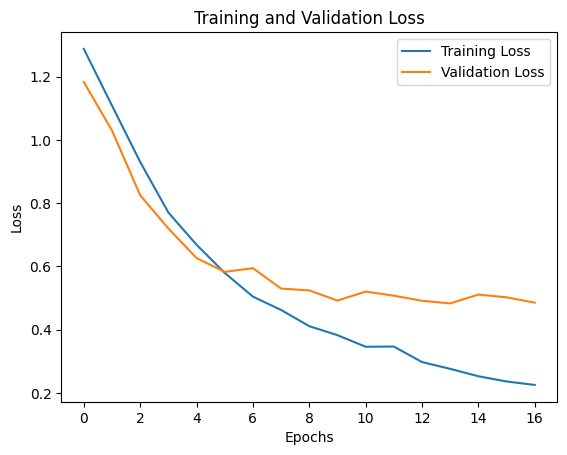

In [20]:
# plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

49/49 [==============================] - 1s 16ms/step
Accuratezza sul test set: 0.84


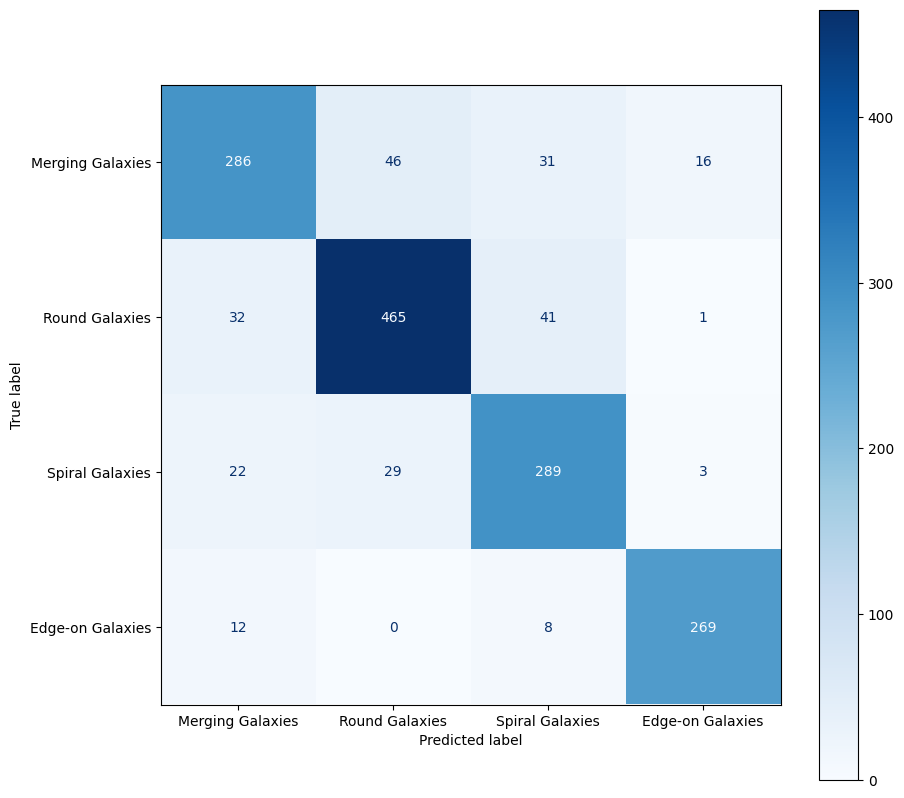

In [22]:
# valutazione sul test set. 
y_pred = np.argmax(model.predict(x_test), axis=-1)

# calcolo dell'accuratezza sul test set
test_accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f"Accuratezza sul test set: {test_accuracy:.2f}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(desired_classes.values()))
fig, ax = plt.subplots(figsize=(10, 10))  # Increase figure size
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()